In [1]:
import h5py
from scipy.io import FortranFile as ff
from astro import constants as c
import numpy as np
from minirats.HaloFinder.py.haloCatalog import haloCatalog as hC

In [2]:
def h5_read_cells(filename):
    f = h5py.File(filename,'r')
    # ~ print f.keys()
    cells = f["cells"][:,:]
    if 'rt' not in filename:
        cell_pos = f["cell_pos"][:,:]
        cell_l = f["cell_l"][:]
        f.close()
        return cells,cell_pos,cell_l
    else:
        f.close()
        return cells     
        
def h5_read_stars(filename):
    f = h5py.File(filename,'r')
    # ~ print f.keys()
    star_mass = f['star_mass'][:]
    star_x = f['star_x'][:]
    star_y = f['star_y'][:]
    star_z = f['star_z'][:]
    star_id = f['star_id'][:]
    star_age = f['star_age'][:] #In Myr
    star_vx = f['star_vx'][:]
    star_vy = f['star_vy'][:]
    star_vz = f['star_vz'][:]
    star_mets = f['star_mets'][:]
    star_minit = f['star_minit'][:]
    f.close()
    return star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit      

def h5_read_rt(filename):
    f = h5py.File(filename,'r')
    cells_rt = f['cells'][:,:]
    f.close()
    return cells_rt

In [3]:
# define a halo catalog object
RamsesDir = '/cral2/sphinx/05_F1000/02_IC20_BP/'
timestep  = 183
hcat = hC(RamsesDir,timestep,HaloDir='Halos/')
readFromRamsesOutput = True

In [4]:
# load the halo catalog 
hcat.load_catalog()
hcat.convert_distances() # convert positions and sizes to code units (store in xxxx_cu variables)

### Construct a density map of star particles in the halo 

In [5]:
# import star particle utils 
from minirats.utils.py.f90utils import star_utils as SU

In [6]:
# load galaxy catalog ! 
gcat = hC(RamsesDir,timestep,galaxies=True)
gcat.load_catalog()
gcat.convert_distances()

In [7]:
# read the star particles ... 
if readFromRamsesOutput:
    nstars = SU.get_tot_nstars(RamsesDir,timestep)   # get nb of star particles in the output
    star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = SU.read_stars_all_props(RamsesDir,timestep,nstars,True,age_conv=True)
else:
    h5CellFile = '%s/Halos/%5.5i/stars.h5'%(RamsesDir,timestep)
    star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = h5_read_stars(h5CellFile)

In [8]:
# select a halo 
myhalo = np.argmax(hcat.mvir[hcat.level==1])
center = [hcat.x_cu[myhalo],hcat.y_cu[myhalo],hcat.z_cu[myhalo]]
radius = 1.0*hcat.rvir_cu[myhalo]

In [9]:
#Center and radius of the galaxy, in code units and kpc
pc2cm = 3.086e18
kpc2cm = 3.086e21
print(center)
print(radius, radius*hcat.info['unit_l']/kpc2cm)

[0.60334516, 0.22293025, 0.1404317]
0.01160544715821743 16.547030037404795


In [14]:
# select star particles in the halo 
d2 = (star_x-center[0])**2 + (star_y-center[1])**2 + (star_z-center[2])**2
ii = np.where(d2 < 1/25*radius*radius)[0]
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = \
      star_mass[ii],star_x[ii],star_y[ii],star_z[ii],star_id[ii],star_age[ii],star_vx[ii],star_vy[ii],star_vz[ii],star_mets[ii],star_minit[ii]


In [15]:
#Number of stellar particles in the Galaxy
print(star_mass.size)

1437033


In [17]:
print(np.argmin(star_age))
print(star_age[14900], star_x[14900], star_y[14900], star_z[14900])

14900
0.002192854999542236 0.6032829284667969 0.22264480590820312 0.14064407348632812


In [34]:
#Stellar mass of the galaxy
print(np.log10(sum(star_mass*hcat.info["unit_d"]*hcat.info["unit_l"]**3/2e33)))

9.19129186011534


In [35]:
# a handy function ... 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_cb(ax,im,label,loc='right',label_size=15):
    if loc=='right':
        axins = inset_axes(ax,width="3%",height="100%",loc=1,borderpad=0)
        cbar = plt.colorbar(im,cax=axins,orientation='vertical')
    if loc=='top':
        axins = inset_axes(ax,width="100%",height="3%",loc=1,borderpad=0)
        cbar = plt.colorbar(im,cax=axins,orientation='horizontal')

    cbar.set_label(label,size=label_size)
    return cbar

def vir_circle(x,y,r,color='black',alpha=1,linestyle='-'):
    fig=plt.gcf()
    c = plt.Circle((x,y),radius=r,fill=False,color=color,alpha=alpha,linestyle=linestyle)
    fig.gca().add_artist(c)



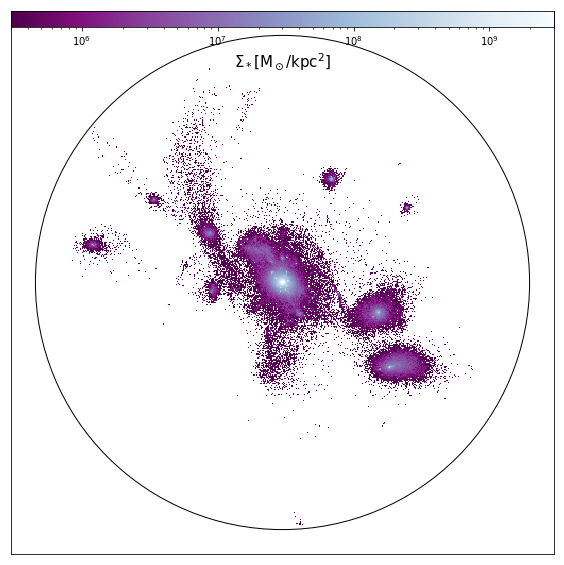

In [37]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
# Star density map
g2Msun = 1./2e33
cu2pc = hcat.info['unit_l']/pc2cm

nx,ny=512,512
xmin,xmax = center[0]-1.1*radius,center[0]+1.1*radius
ymin,ymax = center[1]-1.1*radius,center[1]+1.1*radius
zmin,zmax = center[2]-1.1*radius,center[2]+1.1*radius
starmap,a,b = np.histogram2d(star_x,star_y,bins=(nx,ny), \
                    range=[[xmin ,xmax],[ymin,ymax]],normed=False,weights=star_mass)
starmap = starmap * (hcat.info['unit_d'] * hcat.info['unit_l']**3) * g2Msun 
dx = (xmax-xmin)/float(nx)*hcat.info['unit_l']/pc2cm * 1e-3  # kpc
dy = (ymax-ymin)/float(ny)*hcat.info['unit_l']/pc2cm * 1e-3  # kpc
starmap = starmap / dx/dy 
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
im = plt.imshow(starmap.T,interpolation='nearest',origin='lower',norm=LogNorm(),
                        extent=(xmin*cu2pc/1e3,xmax*cu2pc/1e3,ymin*cu2pc/1e3,ymax*cu2pc/1e3),
                        cmap='BuPu_r',vmin=3e5,vmax=3e9)
vir_circle(center[0]*cu2pc/1e3,center[1]*cu2pc/1e3,radius*cu2pc/1e3,color='black',alpha=1,linestyle='-')

# show galaxies ... 
xg,yg = gcat.x_cu,gcat.y_cu
d2 = (gcat.x_cu-center[0])**2 + (gcat.y_cu-center[1])**2 + (gcat.z_cu-center[2])**2
ii = np.where((d2 < radius**2) & (gcat.level >0))[0]
#for i in ii:
#    vir_circle(xg[i]*cu2pc/1e3,yg[i]*cu2pc/1e3,gcat.rvir_cu[i]*cu2pc/1e3,color='limegreen',alpha=1,linestyle='-')

plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticks([])
add_cb(ax,im,r'$\Sigma_* \rm [M_\odot / kpc^2]$',loc='top')
plt.savefig('star_dens_map_Halo1.pdf')
plt.show()

### Let's now look at the gas properties ! 

In [8]:
from minirats.utils.py import cellutils as cu

In [9]:
# read cells
if readFromRamsesOutput:
    lmax = -1 # read all levels 
    ncells = cu.py_cell_utils.count_cells(RamsesDir,timestep,lmax,center,radius)
    idens   = 1
    ivx,ivy,ivz=2,3,4
    ipre    = 5
    imet    = 6
    ixhii   = 7
    ixheii  = 8
    ixheiii = 9
    readRT=False

In [10]:
# read cells
if readFromRamsesOutput:
    cells,cell_pos,cell_l = cu.py_cell_utils.read_cells_hydro(RamsesDir,timestep,lmax,ncells,[idens,ipre,ixhii,ixheii,ixheiii,imet],center,radius,readRT)
else:
    h5CellFile = '%s/Halos/%5.5i/cells.h5'%(RamsesDir,timestep)
    cells,cell_pos,cell_l = h5_read_cells(h5CellFile)
    h5CellFile = '%s/Halos/%5.5i/cells_rt.h5'%(RamsesDir,timestep)
    cells_rt = h5_read_cells(h5CellFile)

In [11]:
print(ncells)

4929051


In [12]:
rho    = np.array(cells[:,0],dtype='float64')
pres   = np.array(cells[:,1],dtype='float64')
xHII   = np.array(cells[:,2],dtype='float64')
xHeII   = np.array(cells[:,3],dtype='float64')
xHeIII   = np.array(cells[:,4],dtype='float64')
metallicity = np.array(cells[:,5],dtype='float64')

In [13]:
X_frac = 0.76
nH   = rho * hcat.info['unit_nH']
nHe  = 0.25*nH*(1.0-X_frac)/X_frac
nHII = xHII*nH
xHI  = 1e0 - xHII
nHI  = np.maximum(nH*xHI,1e-18)
mu   = 1./( X_frac*(1.+xHII) + 0.25*(1.-X_frac)*(1.+xHeII+2.*xHeIII) )
TK   = pres/rho*mu*hcat.info['unit_T2']  # [K]

In [14]:
#Total gas and dust mass in the galaxy
#Assuming metallicity dependent dust to gas ratio, from Santini et al. 2013,  with solar abundances
Z_OH = 12 + np.log10(4.9e-4*metallicity/0.0134) 
volumes = (0.5**cell_l*hcat.info['unit_l'])**3
gas_mass = rho*hcat.info['unit_d']*volumes
dust_mass = 0.01*np.power(10,Z_OH-8.69)*gas_mass
print(np.log10(sum(gas_mass)/2e33))
print(np.log10(sum(dust_mass)/2e33))

9.753342266619486
7.012995776071266


In [57]:
xloc = cell_pos[:,0]
yloc = cell_pos[:,1]
zloc = cell_pos[:,2]

r = 0.5*radius
xmin,xmax = center[0]-r,center[0]+r
ymin,ymax = center[1]-r,center[1]+r
#zmin,zmax = center[2]-r,center[2]+r
zmin,zmax = center[2]-0.00001,center[2]+0.00001

lmax = cell_l.max()
nx,ny = cu.py_cell_utils.get_map_nxny(lmax,xmin,xmax,ymin,ymax)

cu2pc = hcat.info['unit_l']/pc2cm
R_kpc = hcat.info['unit_l']/pc2cm/1000*r

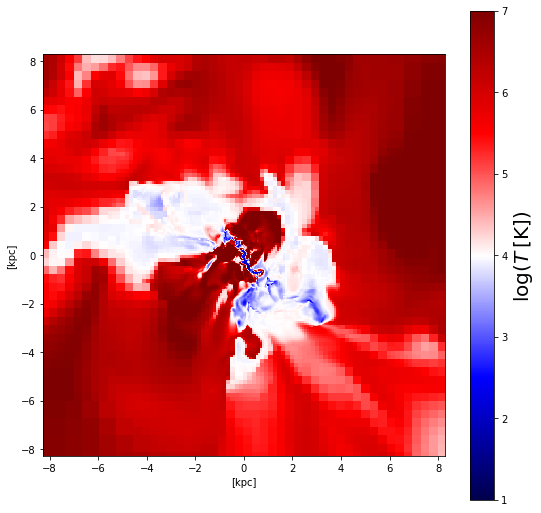

In [61]:
TempMap, w = cu.py_cell_utils.make_map(lmax, False, xmin, xmax, ymin, ymax, zmin, zmax, np.log10(TK), nH, xloc, yloc, zloc, cell_l, nx, ny)
#plt.style.use('dark_background')
plt.figure(figsize=(9,9))
plt.imshow(TempMap, origin='lower',cmap=plt.get_cmap('seismic'), extent=[-R_kpc, R_kpc, -R_kpc, R_kpc])
plt.xlabel('[kpc]')
plt.ylabel('[kpc]')
plt.clim(1, 7)
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{log}(T \: [\mathrm{K}])$', fontsize=20)
plt.savefig('T_map_Halo1.pdf')
plt.show()

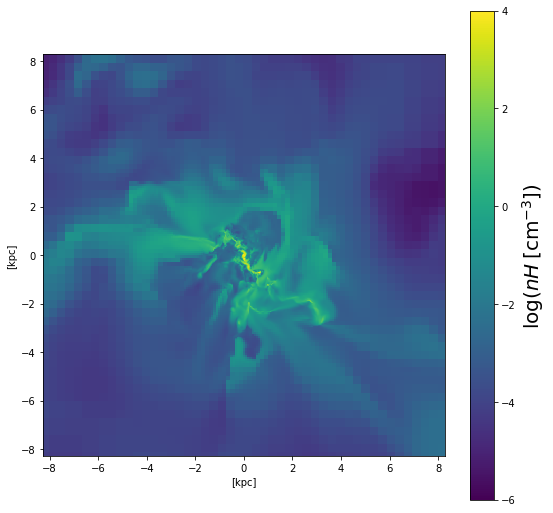

In [62]:
TempMap, w = cu.py_cell_utils.make_map(lmax, False, xmin, xmax, ymin, ymax, zmin, zmax, np.log10(nH), nH, xloc, yloc, zloc, cell_l, nx, ny)
#plt.style.use('dark_background')
plt.figure(figsize=(9,9))
plt.imshow(TempMap, origin='lower', extent=[-R_kpc, R_kpc, -R_kpc, R_kpc]) #cmap=plt.get_cmap('seismic')
plt.xlabel('[kpc]')
plt.ylabel('[kpc]')
plt.clim(-6, 4)
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{log}(nH \: [\mathrm{cm}^{-3}])$', fontsize=20)
plt.savefig('nH_map_Halo1.pdf')
plt.show()

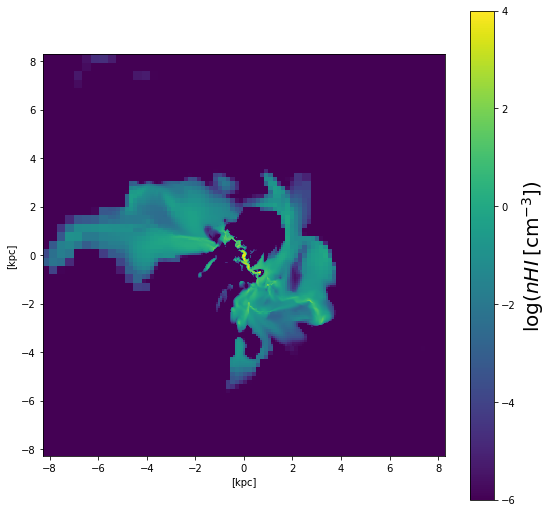

In [63]:
TempMap, w = cu.py_cell_utils.make_map(lmax, False, xmin, xmax, ymin, ymax, zmin, zmax, np.log10(nHI), nH, xloc, yloc, zloc, cell_l, nx, ny)
#plt.style.use('dark_background')
plt.figure(figsize=(9,9))
plt.imshow(TempMap, origin='lower', extent=[-R_kpc, R_kpc, -R_kpc, R_kpc])
plt.xlabel('[kpc]')
plt.ylabel('[kpc]')
plt.clim(-6, 4)
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{log}(nHI \: [\mathrm{cm}^{-3}])$', fontsize=20)
plt.savefig('nHI_map_Halo1.pdf')
plt.show()

In [53]:
# TempMap, w = cu.py_cell_utils.make_map(lmax, False, xmin, xmax, ymin, ymax, zmin, zmax, np.log10(rho_dust), nH, xloc, yloc, zloc, cell_l, nx, ny)
# #plt.style.use('dark_background')
# plt.figure(figsize=(9,9))
# plt.imshow(TempMap, origin='lower', extent=[-R_kpc, R_kpc, -R_kpc, R_kpc], cmap=plt.get_cmap('Reds'))
# plt.xlabel('[kpc]')
# plt.ylabel('[kpc]')
# #plt.clim(-10, 0)
# cbar = plt.colorbar()
# cbar.set_label(r'$\mathrm{log}(\rho_{dust} \: [\mathrm{g \cdot cm}^{-3}])$', fontsize=20)
# plt.show()

In [54]:
# print(np.log10(sum(rho_dust*(0.5**(cell_l)*hcat.info["unit_l"])**3)*g2Msun))